## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**ODIAC Fossil Fuel CO₂ Emissions**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/odiac-ffco2-monthgrid-v2023_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 1 km x 1 km
- **Temporal extent**: January 2000 - December 2022
- **Temporal resolution**: Monthly
- **Unit**: Metric tonnes of carbon per 1 km x 1 km cell per month
- **Utility**: Climate Research

For more, visit the [ODIAC Fossil Fuel CO₂ Emissions](https://earth.gov/ghgcenter/data-catalog/odiac-ffco2-monthgrid-v2023) data overview page.  

## Approach

   1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. Collection processed in this notebook is ODIAC CO₂ emissions version 2023.
   2. Pass the STAC item into raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint
   3. We'll visualize two tiles (side-by-side) allowing for comparison of each of the time points using `folium.plugins.DualMap`
   4. After the visualization, we'll perform zonal statistics for a given polygon.
   

## About the Data

The Open-Data Inventory for Anthropogenic Carbon dioxide (ODIAC) is a high-spatial resolution global emission data product of CO₂ emissions from fossil fuel combustion (Oda and Maksyutov, 2011). ODIAC pioneered the combined use of space-based nighttime light data and individual power plant emission/location profiles to estimate the global spatial extent of fossil fuel CO₂ emissions. With the innovative emission modeling approach, ODIAC achieved the fine picture of global fossil fuel CO₂ emissions at a 1x1km.

For more information regarding this dataset, please visit the [ODIAC Fossil Fuel CO₂ Emissions](https://earth.gov/ghgcenter/data-catalog/odiac-ffco2-monthgrid-v2022) data overview page.

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt
from stats_module import generate_stats, clean_stats, display_stats

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for ODIAC dataset 
collection_name = "odiac-ffco2-monthgrid-v2023"

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=odiac-ffco2-monthgrid-v2023>

Examining the contents of our `collection` under `summaries` we see that the data is available from January 2000 to December 2022. By looking at the `dashboard:time density` we observe that the periodic frequency of these observations is monthly. 

In [4]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 276 items


In [5]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212>

## Visual Comparison Across Time Periods

We will explore changes in fossil fuel emissions in urban egions. In this notebook, we'll explore the impacts of these emissions and explore these changes over time. We'll then visualize the outputs on a map using `folium`. 

In [6]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item.properties["start_datetime"][:7]: item for item in collection.get_items()}

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the ODIAC Fossil Fuel CO₂ Emissions collection, the parameter of interest is “co2-emissions”
asset_name = "co2-emissions"

Now, you will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. You will do this twice, once for January 2020 and again for January 2000, so that we can visualize each event independently. 

In [7]:
# Choose a color map for displaying the first observation (event)
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html

color_map = "rainbow" 

# Make a GET request to retrieve information for the date mentioned below
first_date = items["2020-01"]

# Extract collection name and item ID
collection_id = first_date.collection_id
item_id = first_date.id

object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

{'max': 41440.01171875, 'min': -818.7553100585938}


In [8]:
# Make a GET request to retrieve information for the date mentioned below
january_2020_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=-10,60" #{rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
january_2020_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202001/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-10%2C60'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [9]:
# Make a GET request to retrieve information for the 2000 tile

# Make a GET request to retrieve information for date mentioned below
second_date = items["2000-01"]

# Extract collection name and item ID
collection_id = second_date.collection_id
item_id = second_date.id

object = second_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

january_2000_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=-10,60"
).json()

# Print the properties of the retrieved granule to the console
january_2000_tile

{'max': 28040.880859375, 'min': -626.2506713867188}


{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_200001/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=co2-emissions&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-10%2C60'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Map Out Selected Tiles

In [10]:
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set the initial zoom level and center of map for both tiles
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# Define the first map layer (January 2020)
map_layer_2020 = TileLayer(
    tiles=january_2020_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)

# Add the first layer to the Dual Map
map_layer_2020.add_to(map_.m1)

# Define the second map layer (January 2000)
map_layer_2000 = TileLayer(
    tiles=january_2000_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)

# Add the second layer to the Dual Map
map_layer_2000.add_to(map_.m2)

# Visualize the Dual Map
map_

# Calculating Zonal Statistics
To perform zonal statistics, first we need to create a polygon. 

In [11]:
# Texas, USA
texas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-95, 29], # South-east bounding coordinate
                [-95, 33], # North-east bounding coordinate
                [-104,33], # North-west bounding coordinate
                [-104,29], # South-west bounding coordinate
                [-95, 29]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [13]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 276 items


Now that we created the polygon for the area of interest, we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

With the function above we can generate the statistics for the AOI.

In [ ]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
# This process may take a few minutes to complete 
stats = [generate_stats(item, texas_aoi,asset_name) for item in items]

In [15]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.7438682317733765,
   'max': 420840.1875,
   'mean': 39.4478874206543,
   'count': 177466.0,
   'sum': 7000659.0,
   'std': 1908.1162831441904,
   'median': 3.2146987915039062,
   'majority': 64.48101043701172,
   'minority': 0.7438682317733765,
   'unique': 160218.0,
   'histogram': [[177450, 9, 1, 0, 1, 1, 1, 1, 1, 1],
    [0.7438682317733765,
     42084.6875,
     84168.6328125,
     126252.578125,
     168336.53125,
     210420.46875,
     252504.421875,
     294588.375,
     336672.3125,
     378756.25,
     420840.1875]],
   'valid_percent': 34.23,
   'masked_pixels': 340934.0,
   'valid_pixels': 177466.0,
   'percentile_2': 1.3178801536560059,
   'percentile_98': 220.57638549804688}},
 'datetime': '2022-12-01T00:00:00+00:00'}

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [16]:
# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2022-12-01T00:00:00+00:00,0.743868,420840.18750,39.447887,177466.0,7000659.0,1908.116283,3.214699,64.481010,0.743868,160218.0,"[[177450, 9, 1, 0, 1, 1, 1, 1, 1, 1], [0.74386...",34.23,340934.0,177466.0,1.317880,220.576385,2022-12-01 00:00:00+00:00
1,2022-11-01T00:00:00+00:00,0.608937,343526.96875,32.262497,177466.0,5725496.5,1557.576964,2.635552,52.784710,0.608937,160204.0,"[[177450, 9, 1, 0, 1, 1, 1, 1, 1, 1], [0.60893...",34.23,340934.0,177466.0,1.081165,180.777283,2022-11-01 00:00:00+00:00
2,2022-10-01T00:00:00+00:00,0.617746,348376.68750,32.727840,177466.0,5808079.0,1579.566634,2.674915,53.548267,0.617746,160216.0,"[[177450, 9, 1, 0, 1, 1, 1, 1, 1, 1], [0.61774...",34.23,340934.0,177466.0,1.097266,183.435852,2022-10-01 00:00:00+00:00
3,2022-09-01T00:00:00+00:00,0.737875,417608.00000,39.143070,177466.0,6946564.0,1893.460654,3.190599,63.961494,0.737875,160221.0,"[[177450, 9, 1, 0, 1, 1, 1, 1, 1, 1], [0.73787...",34.23,340934.0,177466.0,1.308810,219.010132,2022-09-01 00:00:00+00:00
4,2022-08-01T00:00:00+00:00,0.910771,516733.53125,48.361969,177466.0,8582605.0,2342.897245,3.935843,78.948669,0.910771,160211.0,"[[177450, 9, 1, 0, 1, 1, 1, 1, 1, 1], [0.91077...",34.23,340934.0,177466.0,1.613806,270.067291,2022-08-01 00:00:00+00:00


## Time-Series Analysis
We can now explore the ODIAC fossil fuel emission time series available (January 2000 -December 2022) for the Texas, Dallas area of USA. We can plot the data set using the code below:

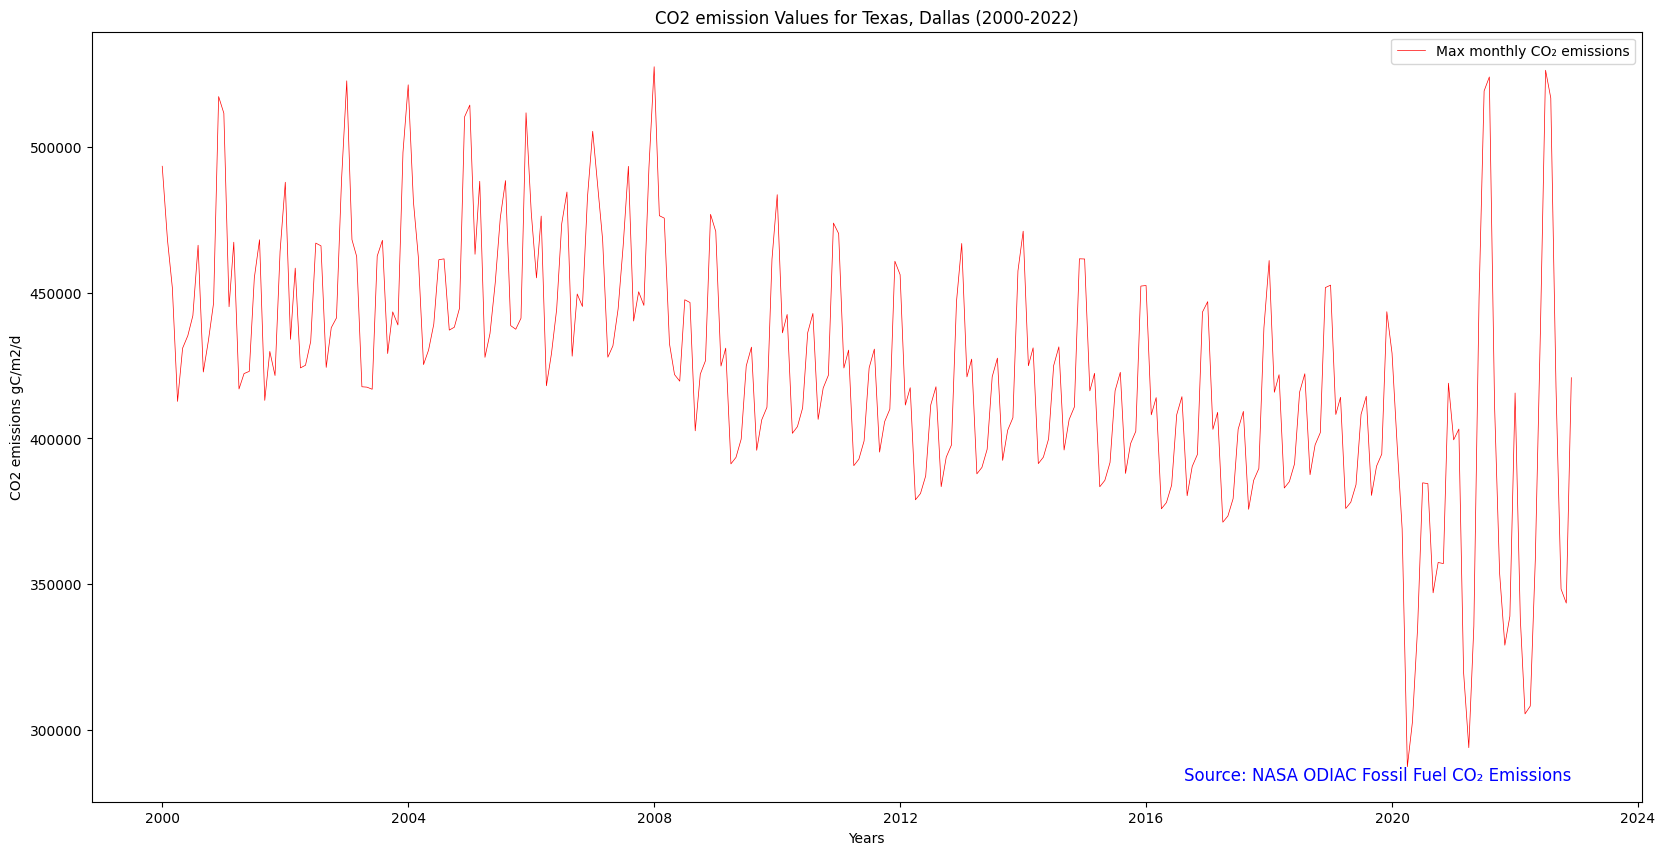

In [17]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CO₂ level
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="Max monthly CO₂ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("CO2 emissions gC/m2/d")

# Insert title for the plot
plt.title("CO2 emission Values for Texas, Dallas (2000-2022)")

###
# Add data citation
plt.text(
    df["date"].iloc[0],           # X-coordinate of the text
    df["max"].min(),              # Y-coordinate of the text




    # Text to be displayed
    "Source: NASA ODIAC Fossil Fuel CO₂ Emissions",                  
    fontsize=12,                             # Font size
    horizontalalignment="right",             # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

## Summary

In this notebook we have successfully explored, analysed and visualized STAC collecetion for ODIAC C02 fossisl fuel emission (2023).

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the CO₂ levels for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Visualizing the Data as a Time Series

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).